## **📄 Document type classification**


### 0. 라이브러리 임포트

In [4]:
%pip install timm albumentations pandas scikit-learn matplotlib -q


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

folder_path = "/home/train"
file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

print(f"파일 개수: {file_count}")

파일 개수: 1570


In [5]:
import os
import random

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

# 데이터 증강할 때 이미지 오버레이용
from albumentations.core.transforms_interface import ImageOnlyTransform

import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import csv


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 1053, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.p

## 3. Baseline Code

### 3.1 데이터 증강

In [5]:
train_dir = '/home/train'
test_dir = '/home/test'
train_csv_dir = 'home/train.csv'
sample_sub_dir = 'home/sample_submission.csv'

img_size = 224

In [6]:
# Augmentation- 이미지 겹치기
class RandomImageOverlay(A.ImageOnlyTransform):
    def __init__(self, overlay_dir, alpha=0.7, always_apply=False, p=0.4):
        super().__init__(always_apply=always_apply, p=p)
        self.overlay_dir = overlay_dir
        self.alpha = alpha
        self.overlay_images = [
            os.path.join(overlay_dir, img)
            for img in os.listdir(overlay_dir)
            if img.endswith(('.png', '.jpg', '.jpeg'))
        ]

    def apply(self, img, **params):
        overlay_path = random.choice(self.overlay_images)
        overlay = cv2.imread(overlay_path)
        overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

        # Resize overlay to match the size of the input image
        overlay = cv2.resize(overlay, (img.shape[1], img.shape[0]))

        # Blend the images
        blended_image = cv2.addWeighted(img, 1 - self.alpha, overlay, self.alpha, 0)
        return blended_image
    
# 오버레이 이미지 경로
overlay_dir = train_dir

In [7]:
# RGB 채널 mean, std 계산
def calculate_mean_std(image_dir):
    means = []
    stds = []
    image_count = 0

    for image_name in os.listdir(image_dir):
        image_path = os.path.join(image_dir, image_name)
        img = cv2.imread(image_path)  # 이미지 읽기 (BGR 포맷)
        if img is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGB 포맷으로 변환
        img = img / 255.0  # 0~1 범위로 정규화

        means.append(np.mean(img, axis=(0, 1)))  # (H, W, C) -> R, G, B 채널별 평균
        stds.append(np.std(img, axis=(0, 1)))   # (H, W, C) -> R, G, B 채널별 표준편차

        image_count += 1

    # 전체 평균과 표준편차 계산
    mean = np.mean(means, axis=0)
    std = np.mean(stds, axis=0)

    return mean, std

mean, std = calculate_mean_std(train_dir)
mean = mean.tolist()
std = std.tolist()

# 결과 출력
print(f"RGB Mean: {mean}")
print(f"RGB Std: {std}")

RGB Mean: [0.574335578735831, 0.5833040601054528, 0.5881892680045149]
RGB Std: [0.18964056010820568, 0.1869425207205775, 0.1850691924647016]


In [8]:
# 긴 변의 길이를 224로 맞춘 뒤 RGB 평균값 padding 추가
class ResizeImage(A.ImageOnlyTransform):
    def __init__(self, img_size=224, always_apply=False, p=1.0):
        super().__init__(always_apply=always_apply, p=p)
        self.img_size = img_size
        self.mean_color = (0, 0, 0)  # 초기화

    def apply(self, img, **params):
        # 이미지 크기 가져오기
        h, w = img.shape[:2]
        
        # 비율을 유지하며 긴 변을 img_size로 맞춤
        if h > w:
            new_h, new_w = self.img_size, int(w * (self.img_size / h))
        else:
            new_h, new_w = int(h * (self.img_size / w)), self.img_size
        
        resized_img = cv2.resize(img, (new_w, new_h))

        # 이미지의 평균 RGB 색상 계산 및 저장
        self.mean_color = tuple(map(int, resized_img.mean(axis=(0, 1))))

        # 패딩 계산
        delta_h = self.img_size - new_h
        delta_w = self.img_size - new_w
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)

        # 패딩 추가
        padded_img = cv2.copyMakeBorder(
            resized_img,
            top, bottom, left, right,  # 위, 아래, 왼쪽, 오른쪽 패딩
            cv2.BORDER_CONSTANT,
            value=self.mean_color  # 평균 RGB 패딩 색상
        )
        
        return padded_img

In [9]:
# 회전하고 생긴 부분 RGB 평균값으로 채우기
class RotateImage(A.ImageOnlyTransform):
    def __init__(self, limit=90, always_apply=False, p=1.0):
        super().__init__(always_apply=always_apply, p=p)
        self.limit = limit

    def apply(self, img, **params):
        # 이미지의 평균 RGB 값 계산
        mean_color = tuple(map(int, img.mean(axis=(0, 1))))

        # 회전 각도 설정
        angle = np.random.uniform(-self.limit, self.limit)

        # 이미지 중심 좌표 계산
        h, w = img.shape[:2]
        center = (w // 2, h // 2)

        # 회전 행렬 생성
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

        # 이미지 회전
        rotated_img = cv2.warpAffine(
            img,
            rotation_matrix,
            (w, h),
            borderMode=cv2.BORDER_CONSTANT,
            borderValue=mean_color  # 계산된 평균 RGB 값으로 패딩
        )
        return rotated_img

In [10]:
# Train데이터 증강
trn_transform = A.Compose([
                        # 이미지 크기 조정
                        ResizeImage(img_size=img_size),
                        
                        # 색 조정
                        A.OneOf([
                                # A.Equalize(), # 명암대비 높이는 변환
                                A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3), # saturation: 채도 / Hue: 색조
                                A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30) # 색상 왜곡
                                # A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.4), # 색조, 채도, 밝기 이동 범위
                                ], p=0.4),

                        # 노이즈 추가
                        A.OneOf([
                                A.GaussNoise(var_limit=(10.0, 20.0), mean=0), # 랜덤한 픽셀값 추가해서 노이즈 줌
                                # A.ImageCompression(quality_lower=5, quality_upper=15, p=0.1), # 압축해서 이미지 품질을 저하시킴
                                ], p=0.3),

                        # 선명도 조정(선명 or 흐릿)
                        A.OneOf([
                                A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8)), # 선명(명암대비)
                                A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8)), # 선명(명암대비)
                                # A.Sharpen(alpha=(0.2, 0.4), lightness=(0.5, 1.0)), # 선명(엣지강조)
                                
                                A.GaussianBlur(blur_limit=(3, 3), sigma_limit=(0.1, 0.5)), # 흐릿
                                # A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.2, alpha_coef=0.08), # 흐릿. 안개 효과, alpha_coef: 안개의 투명도
                                A.RandomSnow(snow_point_lower=0.1, snow_point_upper=0.2, brightness_coeff=2), # 흐릿. 눈 효과, brightness_coeff: 눈의 밝기
                                A.RandomRain(slant_lower=-3, slant_upper=3, drop_length=2, drop_width=1, 
                                        drop_color=(200, 200, 200), blur_value=3, brightness_coefficient=0.7) # 흐릿. 비 효과, slant: 빗방울 기울기
                                ], p=0.4),

                        # Grid Dropout과 random overlay 중 하나만 적용
                        A.OneOf([
                                A.GridDropout(ratio=0.2, unit_size_min=None, unit_size_max=30, holes_number_x=6, holes_number_y=6,
                                        shift_x=0, shift_y=0, random_offset=False, fill_value=0, mask_fill_value=None, always_apply=False, p=0.3),
                                RandomImageOverlay(overlay_dir=overlay_dir, alpha=0.3, always_apply=False, p=0.7),
                                ]),
                        
                        # A.Rotate(limit=(-179, 179), p=0.9, border_mode=cv2.BORDER_CONSTANT, value=(210,210,210)),
                        # Rotate with dynamic padding
                        RotateImage(limit=179, always_apply=False, p=0.9),
                        A.HorizontalFlip(p=0.6),
                        A.Normalize(mean=mean, std=std),
                        ToTensorV2()
                        ])

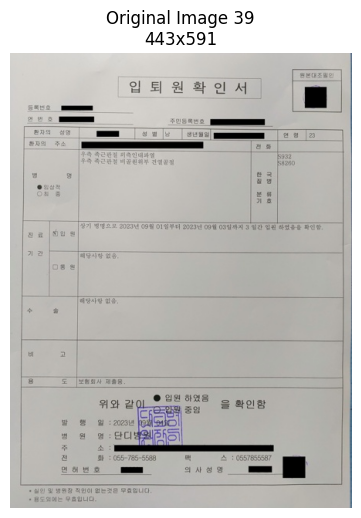

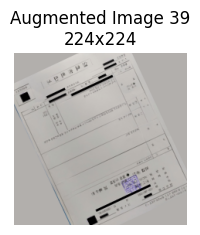

In [11]:
# 이미지 디렉토리와 인덱스 범위 설정
image_dir = train_dir
start_index = 39
end_index = 40

# 이미지 로드
image_paths = sorted(os.listdir(image_dir))[start_index:end_index]
images = [cv2.imread(os.path.join(image_dir, img_path)) for img_path in image_paths]
images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]

# 변환 적용 및 시각화
for i, image in enumerate(images):
    # 변환 적용
    augmented = trn_transform(image=image)
    transformed_image = augmented['image'].permute(1, 2, 0).cpu().numpy()  # 텐서를 다시 이미지로 변환
    transformed_image = (transformed_image * np.array(std) + np.array(mean))  # 정규화를 되돌림
    transformed_image = (transformed_image * 255).astype(np.uint8)  # 이미지를 다시 0-255 범위로 변환

    # 원본 이미지 크기
    original_h, original_w, _ = image.shape
    # 변환된 이미지 크기
    transformed_h, transformed_w, = img_size, img_size

    # 각 이미지의 플롯 크기를 실제 이미지 크기의 1/100로 설정
    original_figsize = (original_w / 100, original_h / 100)
    transformed_figsize = (transformed_w / 100, transformed_h / 100)
    # print(f'original_figsize={original_figsize}',f'transformed_figsize={transformed_figsize}')

    # 원본 이미지 출력
    fig, ax = plt.subplots(1, 1, figsize=original_figsize)
    ax.imshow(image)
    ax.set_title(f'Original Image {i + start_index}\n{original_w}x{original_h}')
    ax.axis('off')
    # plt.tight_layout()
    plt.show()

    # 변환된 이미지 출력
    fig, ax = plt.subplots(1, 1, figsize=transformed_figsize)
    ax.imshow(transformed_image)
    ax.set_title(f'Augmented Image {i + start_index}\n{transformed_w}x{transformed_h}')
    ax.axis('off')
    # plt.tight_layout()
    plt.show()


### 3.2 모델 11개 돌려보고 결과 측정

In [13]:
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

In [14]:
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none=True)

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

In [15]:
# Dataset 정의
trn_dataset = ImageDataset(
    train_csv_dir,
    train_dir,
    transform=trn_transform
)

print(len(trn_dataset))

1570


In [16]:
BATCH_SIZE=128
num_workers=8
EPOCHS=20

In [17]:
# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)

In [18]:
# 시드 고정
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [19]:
# 모델 불러오기
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [20]:
torch.cuda.empty_cache()

In [23]:
# 모델 리스트
models_to_train = [
    'resnet50', 'resnet101', 'efficientnet_b2', 'efficientnet_b3',
    'vit_small_patch16_224', 'vit_base_patch16_224', 
    # 'vit_base_resnet50_224_in21k', 
    'swin_tiny_patch4_window7_224', 'swin_small_patch4_window7_224',
    'coatnet_0_rw_224',
    # 'coatnet_1_rw_224'
]

# 데이터 분리 (8:2)
def split_dataset(csv_path, train_dir):
    data = pd.read_csv(csv_path)
    train_data, val_data = train_test_split(data, test_size=0.2, random_state=SEED, stratify=data['target'])
    
    train_csv_path = "/home/split_train.csv"
    val_csv_path =  "/home/split_val.csv"
    train_data.to_csv(train_csv_path, index=False)
    val_data.to_csv(val_csv_path, index=False)
    return train_csv_path, val_csv_path

train_csv_path, val_csv_path = split_dataset(train_csv_dir, train_dir)

# Validation Dataset 정의
val_dataset = ImageDataset(
    val_csv_path,
    train_dir,
    transform=trn_transform
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

# Validation 평가 함수
def validate(loader, model, loss_fn, device):
    model.eval()
    val_loss = 0
    preds_list = []
    targets_list = []

    with torch.no_grad():
        for image, targets in loader:
            image = image.to(device)
            targets = targets.to(device)

            preds = model(image)
            loss = loss_fn(preds, targets)

            val_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).cpu().numpy())
            targets_list.extend(targets.cpu().numpy())

    val_loss /= len(loader)
    val_acc = accuracy_score(targets_list, preds_list)
    val_f1 = f1_score(targets_list, preds_list, average='macro')

    return {"val_loss": val_loss, "val_acc": val_acc, "val_f1": val_f1}

# 체크포인트 저장 함수
def save_checkpoint(model, optimizer, epoch, filepath):
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch
    }
    torch.save(checkpoint, filepath)

# 체크포인트 로드 함수
def load_checkpoint(filepath, model, optimizer):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    return model, optimizer, start_epoch

import pandas as pd

# 학습 및 평가 루프
results = {}
patience = 5 
model_num = 1

for model_name in models_to_train:
    print(f"Training {model_name}...")
    
    try:
        # 모델 생성
        model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)

        # Learning Rate 설정
        if 'resnet' in model_name or 'efficientnet' in model_name:
            LR = 1e-3
        else:
            LR = 1e-4

        optimizer = Adam(model.parameters(), lr=LR)
        loss_fn = nn.CrossEntropyLoss()

        best_val_f1 = 0
        patience_counter = 0

        # 학습 로그를 저장할 리스트 초기화
        train_loss_log = []
        train_acc_log = []
        train_f1_log = []
        val_loss_log = []
        val_acc_log = []
        val_f1_log = []

        for epoch in range(EPOCHS):
            # Train
            train_metrics = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
            train_metrics['epoch'] = epoch

            # Validate
            val_metrics = validate(val_loader, model, loss_fn, device)
            train_metrics.update(val_metrics)

            # Check for improvement
            if val_metrics['val_f1'] > best_val_f1:
                best_val_f1 = val_metrics['val_f1']
                patience_counter = 0
                save_checkpoint(model, optimizer, epoch, f"/home/bestpth{model_num}_{model_name}_best.pth")  # Save best model
            else:
                patience_counter += 1

            # Save metrics to logs
            train_loss_log.append(train_metrics['train_loss'])
            train_acc_log.append(train_metrics['train_acc'])
            train_f1_log.append(train_metrics['train_f1'])
            val_loss_log.append(val_metrics['val_loss'])
            val_acc_log.append(val_metrics['val_acc'])
            val_f1_log.append(val_metrics['val_f1'])

            # Log metrics
            log = f"Epoch {epoch+1}/{EPOCHS} - " + ", ".join([f"{k}: {v:.4f}" for k, v in train_metrics.items()])
            print(log)

            # Early Stopping 조건 확인
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # 기록 저장
        results[model_name] = {"best_val_f1": best_val_f1}

        # 학습 및 검증 로그를 DataFrame으로 변환
        logs_df = pd.DataFrame({
            "epoch": range(len(train_loss_log)),
            "train_loss": train_loss_log,
            "train_acc": train_acc_log,
            "train_f1": train_f1_log,
            "val_loss": val_loss_log,
            "val_acc": val_acc_log,
            "val_f1": val_f1_log
        })

        # CSV 파일로 저장
        logs_filename = f"/home/logs{model_num}_{model_name}.csv"
        logs_df.to_csv(logs_filename, index=False)
        model_num += 1
        print(f"Logs saved to {logs_filename}")

    except RuntimeError as e:
        if "CUDA out of memory" in str(e):
            print(f"Skipping {model_name} due to CUDA out of memory error.")
            torch.cuda.empty_cache()  # GPU 메모리 캐시 비우기
        else:
            raise e  # 다른 에러는 그대로 발생시킴

# 결과 출력
for model_name, metrics in results.items():
    print(f"Model: {model_name}, Best Validation F1: {metrics['best_val_f1']:.4f}")

Training resnet50...


Loss: 2.1210: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


Epoch 1/20 - train_loss: 2.5173, train_acc: 0.2994, train_f1: 0.2537, epoch: 0.0000, val_loss: 2.2270, val_acc: 0.3376, val_f1: 0.2576


Loss: 1.3827: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


Epoch 2/20 - train_loss: 1.6238, train_acc: 0.5860, train_f1: 0.5015, epoch: 1.0000, val_loss: 1.1962, val_acc: 0.5987, val_f1: 0.5067


Loss: 1.0168: 100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


Epoch 3/20 - train_loss: 0.9551, train_acc: 0.6854, train_f1: 0.6104, epoch: 2.0000, val_loss: 0.7308, val_acc: 0.7261, val_f1: 0.6480


Loss: 0.6413: 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


Epoch 4/20 - train_loss: 0.6578, train_acc: 0.7764, train_f1: 0.7310, epoch: 3.0000, val_loss: 0.5602, val_acc: 0.7803, val_f1: 0.7334


Loss: 0.4224: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


Epoch 5/20 - train_loss: 0.5209, train_acc: 0.8134, train_f1: 0.7832, epoch: 4.0000, val_loss: 0.6240, val_acc: 0.7484, val_f1: 0.7171


Loss: 0.3095: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


Epoch 6/20 - train_loss: 0.4467, train_acc: 0.8389, train_f1: 0.8154, epoch: 5.0000, val_loss: 0.4238, val_acc: 0.8694, val_f1: 0.8358


Loss: 0.5400: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


Epoch 7/20 - train_loss: 0.4277, train_acc: 0.8471, train_f1: 0.8179, epoch: 6.0000, val_loss: 0.4264, val_acc: 0.8471, val_f1: 0.8057


Loss: 0.2846: 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


Epoch 8/20 - train_loss: 0.3515, train_acc: 0.8662, train_f1: 0.8447, epoch: 7.0000, val_loss: 0.3329, val_acc: 0.8631, val_f1: 0.8474


Loss: 0.2462: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


Epoch 9/20 - train_loss: 0.3325, train_acc: 0.8752, train_f1: 0.8573, epoch: 8.0000, val_loss: 0.3576, val_acc: 0.8726, val_f1: 0.8635


Loss: 0.4133: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


Epoch 10/20 - train_loss: 0.3190, train_acc: 0.8854, train_f1: 0.8745, epoch: 9.0000, val_loss: 0.3628, val_acc: 0.8854, val_f1: 0.8668


Loss: 0.4848: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


Epoch 11/20 - train_loss: 0.3220, train_acc: 0.8885, train_f1: 0.8777, epoch: 10.0000, val_loss: 0.3335, val_acc: 0.8822, val_f1: 0.8653


Loss: 0.4197: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


Epoch 12/20 - train_loss: 0.2827, train_acc: 0.9019, train_f1: 0.8892, epoch: 11.0000, val_loss: 0.3406, val_acc: 0.8854, val_f1: 0.8776


Loss: 0.2183: 100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


Epoch 13/20 - train_loss: 0.2614, train_acc: 0.8955, train_f1: 0.8895, epoch: 12.0000, val_loss: 0.3027, val_acc: 0.8981, val_f1: 0.8904


Loss: 0.4007: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


Epoch 14/20 - train_loss: 0.2399, train_acc: 0.9108, train_f1: 0.9034, epoch: 13.0000, val_loss: 0.2087, val_acc: 0.9331, val_f1: 0.9270


Loss: 0.3684: 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


Epoch 15/20 - train_loss: 0.2162, train_acc: 0.9242, train_f1: 0.9213, epoch: 14.0000, val_loss: 0.2376, val_acc: 0.9204, val_f1: 0.9164


Loss: 0.2544: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


Epoch 16/20 - train_loss: 0.2080, train_acc: 0.9268, train_f1: 0.9199, epoch: 15.0000, val_loss: 0.1999, val_acc: 0.9363, val_f1: 0.9338


Loss: 0.3291: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


Epoch 17/20 - train_loss: 0.2137, train_acc: 0.9229, train_f1: 0.9184, epoch: 16.0000, val_loss: 0.2154, val_acc: 0.9076, val_f1: 0.9023


Loss: 0.1259: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


Epoch 18/20 - train_loss: 0.1706, train_acc: 0.9414, train_f1: 0.9385, epoch: 17.0000, val_loss: 0.1555, val_acc: 0.9427, val_f1: 0.9415


Loss: 0.1351: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


Epoch 19/20 - train_loss: 0.1764, train_acc: 0.9389, train_f1: 0.9345, epoch: 18.0000, val_loss: 0.1911, val_acc: 0.9268, val_f1: 0.9236


Loss: 0.2329: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s]


Epoch 20/20 - train_loss: 0.1711, train_acc: 0.9382, train_f1: 0.9327, epoch: 19.0000, val_loss: 0.1889, val_acc: 0.9108, val_f1: 0.9020
Logs saved to /home/logs1_resnet50.csv
Training resnet101...


Loss: 2.6324: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


Epoch 1/20 - train_loss: 2.7296, train_acc: 0.1955, train_f1: 0.1656, epoch: 0.0000, val_loss: 2.4898, val_acc: 0.3726, val_f1: 0.2722


Loss: 1.3839: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch 2/20 - train_loss: 1.8584, train_acc: 0.5229, train_f1: 0.4461, epoch: 1.0000, val_loss: 1.6430, val_acc: 0.5064, val_f1: 0.4067


Loss: 0.6547: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch 3/20 - train_loss: 1.0088, train_acc: 0.6650, train_f1: 0.5968, epoch: 2.0000, val_loss: 1.2719, val_acc: 0.5924, val_f1: 0.4971


Loss: 0.6955: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]


Epoch 4/20 - train_loss: 0.7091, train_acc: 0.7459, train_f1: 0.7084, epoch: 3.0000, val_loss: 0.8149, val_acc: 0.7134, val_f1: 0.6644


Loss: 0.7730: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]


Epoch 5/20 - train_loss: 0.6068, train_acc: 0.7790, train_f1: 0.7520, epoch: 4.0000, val_loss: 0.5282, val_acc: 0.7994, val_f1: 0.7549


Loss: 0.6429: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


Epoch 6/20 - train_loss: 0.5229, train_acc: 0.8070, train_f1: 0.7807, epoch: 5.0000, val_loss: 0.4836, val_acc: 0.8408, val_f1: 0.8124


Loss: 0.4040: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]


Epoch 7/20 - train_loss: 0.4299, train_acc: 0.8427, train_f1: 0.8095, epoch: 6.0000, val_loss: 0.5354, val_acc: 0.8185, val_f1: 0.7893


Loss: 0.4445: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]


Epoch 8/20 - train_loss: 0.4069, train_acc: 0.8478, train_f1: 0.8273, epoch: 7.0000, val_loss: 0.4165, val_acc: 0.8503, val_f1: 0.8250


Loss: 0.2771: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Epoch 9/20 - train_loss: 0.3503, train_acc: 0.8580, train_f1: 0.8415, epoch: 8.0000, val_loss: 0.3937, val_acc: 0.8662, val_f1: 0.8421


Loss: 0.4312: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Epoch 10/20 - train_loss: 0.3425, train_acc: 0.8777, train_f1: 0.8654, epoch: 9.0000, val_loss: 0.3871, val_acc: 0.8854, val_f1: 0.8714


Loss: 0.6103: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


Epoch 11/20 - train_loss: 0.3186, train_acc: 0.8904, train_f1: 0.8799, epoch: 10.0000, val_loss: 0.3799, val_acc: 0.8822, val_f1: 0.8814


Loss: 0.3272: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


Epoch 12/20 - train_loss: 0.3204, train_acc: 0.8828, train_f1: 0.8720, epoch: 11.0000, val_loss: 0.3615, val_acc: 0.8694, val_f1: 0.8542


Loss: 0.6932: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


Epoch 13/20 - train_loss: 0.3151, train_acc: 0.8892, train_f1: 0.8797, epoch: 12.0000, val_loss: 0.3143, val_acc: 0.8917, val_f1: 0.8819


Loss: 0.4181: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


Epoch 14/20 - train_loss: 0.2779, train_acc: 0.9025, train_f1: 0.8950, epoch: 13.0000, val_loss: 0.2872, val_acc: 0.8854, val_f1: 0.8746


Loss: 0.2940: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Epoch 15/20 - train_loss: 0.2644, train_acc: 0.8987, train_f1: 0.8882, epoch: 14.0000, val_loss: 0.2077, val_acc: 0.9363, val_f1: 0.9320


Loss: 0.5263: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


Epoch 16/20 - train_loss: 0.2655, train_acc: 0.9038, train_f1: 0.8935, epoch: 15.0000, val_loss: 0.2435, val_acc: 0.9236, val_f1: 0.9223


Loss: 0.6118: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]


Epoch 17/20 - train_loss: 0.2719, train_acc: 0.9089, train_f1: 0.9021, epoch: 16.0000, val_loss: 0.2614, val_acc: 0.9076, val_f1: 0.9040


Loss: 0.2037: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


Epoch 18/20 - train_loss: 0.2477, train_acc: 0.9096, train_f1: 0.9061, epoch: 17.0000, val_loss: 0.2916, val_acc: 0.9140, val_f1: 0.9041


Loss: 0.2029: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]


Epoch 19/20 - train_loss: 0.2151, train_acc: 0.9204, train_f1: 0.9164, epoch: 18.0000, val_loss: 0.2135, val_acc: 0.9172, val_f1: 0.9073


Loss: 0.1630: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


Epoch 20/20 - train_loss: 0.1888, train_acc: 0.9248, train_f1: 0.9201, epoch: 19.0000, val_loss: 0.1831, val_acc: 0.9299, val_f1: 0.9273
Early stopping at epoch 20
Logs saved to /home/logs2_resnet101.csv
Training efficientnet_b2...


Loss: 1.0480: 100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


Epoch 1/20 - train_loss: 1.7801, train_acc: 0.4917, train_f1: 0.4560, epoch: 0.0000, val_loss: 1.0628, val_acc: 0.6879, val_f1: 0.6531


Loss: 0.6205: 100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


Epoch 2/20 - train_loss: 0.8171, train_acc: 0.7344, train_f1: 0.7167, epoch: 1.0000, val_loss: 0.8197, val_acc: 0.7611, val_f1: 0.7217


Loss: 0.5452: 100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


Epoch 3/20 - train_loss: 0.5717, train_acc: 0.8057, train_f1: 0.7834, epoch: 2.0000, val_loss: 0.5202, val_acc: 0.8535, val_f1: 0.8300


Loss: 0.3513: 100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


Epoch 4/20 - train_loss: 0.4152, train_acc: 0.8433, train_f1: 0.8247, epoch: 3.0000, val_loss: 0.2947, val_acc: 0.8917, val_f1: 0.8675


Loss: 0.1045: 100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


Epoch 5/20 - train_loss: 0.4034, train_acc: 0.8580, train_f1: 0.8442, epoch: 4.0000, val_loss: 0.3733, val_acc: 0.8662, val_f1: 0.8545


Loss: 0.1046: 100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


Epoch 6/20 - train_loss: 0.3237, train_acc: 0.8790, train_f1: 0.8662, epoch: 5.0000, val_loss: 0.2375, val_acc: 0.9013, val_f1: 0.8949


Loss: 0.2892: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


Epoch 7/20 - train_loss: 0.2822, train_acc: 0.8924, train_f1: 0.8828, epoch: 6.0000, val_loss: 0.2767, val_acc: 0.9076, val_f1: 0.9026


Loss: 0.3380: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


Epoch 8/20 - train_loss: 0.2752, train_acc: 0.9076, train_f1: 0.9039, epoch: 7.0000, val_loss: 0.3004, val_acc: 0.8981, val_f1: 0.8957


Loss: 0.3226: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


Epoch 9/20 - train_loss: 0.2759, train_acc: 0.8981, train_f1: 0.8920, epoch: 8.0000, val_loss: 0.1901, val_acc: 0.9363, val_f1: 0.9345


Loss: 0.1723: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


Epoch 10/20 - train_loss: 0.2499, train_acc: 0.9089, train_f1: 0.9041, epoch: 9.0000, val_loss: 0.1804, val_acc: 0.9490, val_f1: 0.9467


Loss: 0.2308: 100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


Epoch 11/20 - train_loss: 0.2055, train_acc: 0.9268, train_f1: 0.9233, epoch: 10.0000, val_loss: 0.1604, val_acc: 0.9331, val_f1: 0.9229


Loss: 0.3689: 100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


Epoch 12/20 - train_loss: 0.2055, train_acc: 0.9261, train_f1: 0.9213, epoch: 11.0000, val_loss: 0.1603, val_acc: 0.9459, val_f1: 0.9413


Loss: 0.2935: 100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


Epoch 13/20 - train_loss: 0.2246, train_acc: 0.9166, train_f1: 0.9158, epoch: 12.0000, val_loss: 0.1767, val_acc: 0.9363, val_f1: 0.9365


Loss: 0.2794: 100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


Epoch 14/20 - train_loss: 0.2126, train_acc: 0.9280, train_f1: 0.9252, epoch: 13.0000, val_loss: 0.1448, val_acc: 0.9427, val_f1: 0.9394


Loss: 0.2930: 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


Epoch 15/20 - train_loss: 0.2241, train_acc: 0.9236, train_f1: 0.9172, epoch: 14.0000, val_loss: 0.1689, val_acc: 0.9299, val_f1: 0.9271
Early stopping at epoch 15
Logs saved to /home/logs3_efficientnet_b2.csv
Training efficientnet_b3...


Loss: 0.9721: 100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


Epoch 1/20 - train_loss: 1.8387, train_acc: 0.4662, train_f1: 0.4298, epoch: 0.0000, val_loss: 0.9571, val_acc: 0.6943, val_f1: 0.6575


Loss: 0.5956: 100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Epoch 2/20 - train_loss: 0.7286, train_acc: 0.7605, train_f1: 0.7355, epoch: 1.0000, val_loss: 0.6406, val_acc: 0.7962, val_f1: 0.7780


Loss: 1.0726: 100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


Epoch 3/20 - train_loss: 0.5410, train_acc: 0.8242, train_f1: 0.8062, epoch: 2.0000, val_loss: 0.3587, val_acc: 0.8631, val_f1: 0.8424


Loss: 0.5502: 100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


Epoch 4/20 - train_loss: 0.4617, train_acc: 0.8395, train_f1: 0.8245, epoch: 3.0000, val_loss: 0.4112, val_acc: 0.8726, val_f1: 0.8477


Loss: 0.3418: 100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


Epoch 5/20 - train_loss: 0.3720, train_acc: 0.8669, train_f1: 0.8499, epoch: 4.0000, val_loss: 0.4135, val_acc: 0.8694, val_f1: 0.8577


Loss: 0.1915: 100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


Epoch 6/20 - train_loss: 0.3167, train_acc: 0.8841, train_f1: 0.8716, epoch: 5.0000, val_loss: 0.2501, val_acc: 0.9204, val_f1: 0.9083


Loss: 0.2092: 100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


Epoch 7/20 - train_loss: 0.2718, train_acc: 0.8930, train_f1: 0.8793, epoch: 6.0000, val_loss: 0.2813, val_acc: 0.8981, val_f1: 0.8950


Loss: 0.3152: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 8/20 - train_loss: 0.3202, train_acc: 0.8879, train_f1: 0.8787, epoch: 7.0000, val_loss: 0.2823, val_acc: 0.9299, val_f1: 0.9218


Loss: 0.3163: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 9/20 - train_loss: 0.2726, train_acc: 0.8962, train_f1: 0.8855, epoch: 8.0000, val_loss: 0.1772, val_acc: 0.9459, val_f1: 0.9316


Loss: 0.3147: 100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


Epoch 10/20 - train_loss: 0.2580, train_acc: 0.9070, train_f1: 0.8992, epoch: 9.0000, val_loss: 0.2004, val_acc: 0.9331, val_f1: 0.9176


Loss: 0.1285: 100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


Epoch 11/20 - train_loss: 0.2273, train_acc: 0.9159, train_f1: 0.9098, epoch: 10.0000, val_loss: 0.2165, val_acc: 0.9204, val_f1: 0.9148


Loss: 0.3366: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 12/20 - train_loss: 0.2208, train_acc: 0.9280, train_f1: 0.9220, epoch: 11.0000, val_loss: 0.2571, val_acc: 0.9076, val_f1: 0.8956


Loss: 0.2411: 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


Epoch 13/20 - train_loss: 0.2148, train_acc: 0.9287, train_f1: 0.9238, epoch: 12.0000, val_loss: 0.1375, val_acc: 0.9554, val_f1: 0.9516


Loss: 0.1644: 100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


Epoch 14/20 - train_loss: 0.1516, train_acc: 0.9427, train_f1: 0.9387, epoch: 13.0000, val_loss: 0.2199, val_acc: 0.9363, val_f1: 0.9300


Loss: 0.3837: 100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Epoch 15/20 - train_loss: 0.1728, train_acc: 0.9395, train_f1: 0.9370, epoch: 14.0000, val_loss: 0.1173, val_acc: 0.9554, val_f1: 0.9506


Loss: 0.2122: 100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


Epoch 16/20 - train_loss: 0.1643, train_acc: 0.9484, train_f1: 0.9464, epoch: 15.0000, val_loss: 0.1510, val_acc: 0.9554, val_f1: 0.9567


Loss: 0.1323: 100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


Epoch 17/20 - train_loss: 0.1877, train_acc: 0.9331, train_f1: 0.9284, epoch: 16.0000, val_loss: 0.1321, val_acc: 0.9459, val_f1: 0.9406


Loss: 0.4197: 100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


Epoch 18/20 - train_loss: 0.1622, train_acc: 0.9459, train_f1: 0.9445, epoch: 17.0000, val_loss: 0.1773, val_acc: 0.9490, val_f1: 0.9436


Loss: 0.2509: 100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


Epoch 19/20 - train_loss: 0.1685, train_acc: 0.9376, train_f1: 0.9349, epoch: 18.0000, val_loss: 0.1698, val_acc: 0.9427, val_f1: 0.9404


Loss: 0.1793: 100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


Epoch 20/20 - train_loss: 0.1432, train_acc: 0.9490, train_f1: 0.9469, epoch: 19.0000, val_loss: 0.1354, val_acc: 0.9490, val_f1: 0.9495
Logs saved to /home/logs4_efficientnet_b3.csv
Training vit_small_patch16_224...


Loss: 1.5714: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


Epoch 1/20 - train_loss: 2.0196, train_acc: 0.3898, train_f1: 0.3595, epoch: 0.0000, val_loss: 1.2403, val_acc: 0.5987, val_f1: 0.5470


Loss: 0.5655: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


Epoch 2/20 - train_loss: 0.9230, train_acc: 0.7096, train_f1: 0.6613, epoch: 1.0000, val_loss: 0.7522, val_acc: 0.7707, val_f1: 0.7304


Loss: 0.6093: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 3/20 - train_loss: 0.6775, train_acc: 0.7701, train_f1: 0.7479, epoch: 2.0000, val_loss: 0.5435, val_acc: 0.7994, val_f1: 0.7606


Loss: 0.5026: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


Epoch 4/20 - train_loss: 0.5289, train_acc: 0.8204, train_f1: 0.8000, epoch: 3.0000, val_loss: 0.5233, val_acc: 0.8089, val_f1: 0.7699


Loss: 0.4433: 100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


Epoch 5/20 - train_loss: 0.4827, train_acc: 0.8197, train_f1: 0.7903, epoch: 4.0000, val_loss: 0.4215, val_acc: 0.8408, val_f1: 0.8182


Loss: 0.3927: 100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


Epoch 6/20 - train_loss: 0.4253, train_acc: 0.8573, train_f1: 0.8391, epoch: 5.0000, val_loss: 0.3386, val_acc: 0.8885, val_f1: 0.8854


Loss: 0.3614: 100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


Epoch 7/20 - train_loss: 0.3712, train_acc: 0.8573, train_f1: 0.8447, epoch: 6.0000, val_loss: 0.3334, val_acc: 0.8694, val_f1: 0.8301


Loss: 0.5293: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


Epoch 8/20 - train_loss: 0.3640, train_acc: 0.8688, train_f1: 0.8539, epoch: 7.0000, val_loss: 0.2927, val_acc: 0.8917, val_f1: 0.8767


Loss: 0.1793: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


Epoch 9/20 - train_loss: 0.2945, train_acc: 0.8892, train_f1: 0.8798, epoch: 8.0000, val_loss: 0.3244, val_acc: 0.8790, val_f1: 0.8474


Loss: 0.3270: 100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


Epoch 10/20 - train_loss: 0.2904, train_acc: 0.8943, train_f1: 0.8861, epoch: 9.0000, val_loss: 0.2625, val_acc: 0.9108, val_f1: 0.8953


Loss: 0.2510: 100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


Epoch 11/20 - train_loss: 0.2718, train_acc: 0.8930, train_f1: 0.8820, epoch: 10.0000, val_loss: 0.2610, val_acc: 0.9172, val_f1: 0.9052


Loss: 0.2634: 100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


Epoch 12/20 - train_loss: 0.2790, train_acc: 0.8930, train_f1: 0.8835, epoch: 11.0000, val_loss: 0.2976, val_acc: 0.8917, val_f1: 0.8845


Loss: 0.1883: 100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


Epoch 13/20 - train_loss: 0.2521, train_acc: 0.9064, train_f1: 0.9004, epoch: 12.0000, val_loss: 0.2196, val_acc: 0.9299, val_f1: 0.9144


Loss: 0.1992: 100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


Epoch 14/20 - train_loss: 0.2527, train_acc: 0.9025, train_f1: 0.8908, epoch: 13.0000, val_loss: 0.2854, val_acc: 0.8822, val_f1: 0.8705


Loss: 0.2907: 100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


Epoch 15/20 - train_loss: 0.2623, train_acc: 0.8981, train_f1: 0.8894, epoch: 14.0000, val_loss: 0.2246, val_acc: 0.9204, val_f1: 0.9106


Loss: 0.1444: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


Epoch 16/20 - train_loss: 0.2139, train_acc: 0.9121, train_f1: 0.9095, epoch: 15.0000, val_loss: 0.2092, val_acc: 0.9268, val_f1: 0.9118


Loss: 0.2801: 100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


Epoch 17/20 - train_loss: 0.2482, train_acc: 0.9013, train_f1: 0.8942, epoch: 16.0000, val_loss: 0.2725, val_acc: 0.8854, val_f1: 0.8805


Loss: 0.0711: 100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


Epoch 18/20 - train_loss: 0.2518, train_acc: 0.9070, train_f1: 0.8992, epoch: 17.0000, val_loss: 0.2434, val_acc: 0.9299, val_f1: 0.9273


Loss: 0.1410: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


Epoch 19/20 - train_loss: 0.2122, train_acc: 0.9185, train_f1: 0.9107, epoch: 18.0000, val_loss: 0.2275, val_acc: 0.9363, val_f1: 0.9319


Loss: 0.1155: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 20/20 - train_loss: 0.1897, train_acc: 0.9293, train_f1: 0.9261, epoch: 19.0000, val_loss: 0.2044, val_acc: 0.9363, val_f1: 0.9301
Logs saved to /home/logs5_vit_small_patch16_224.csv
Training vit_base_patch16_224...


Loss: 1.4767: 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]


Epoch 1/20 - train_loss: 2.0685, train_acc: 0.3439, train_f1: 0.3084, epoch: 0.0000, val_loss: 1.2862, val_acc: 0.4968, val_f1: 0.4176


Loss: 0.8455: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]


Epoch 2/20 - train_loss: 1.1604, train_acc: 0.5930, train_f1: 0.5574, epoch: 1.0000, val_loss: 0.7408, val_acc: 0.7643, val_f1: 0.7241


Loss: 0.6752: 100%|██████████| 13/13 [00:12<00:00,  1.08it/s]


Epoch 3/20 - train_loss: 0.6395, train_acc: 0.7764, train_f1: 0.7451, epoch: 2.0000, val_loss: 0.6042, val_acc: 0.7866, val_f1: 0.7599


Loss: 0.3088: 100%|██████████| 13/13 [00:12<00:00,  1.08it/s]


Epoch 4/20 - train_loss: 0.4830, train_acc: 0.8191, train_f1: 0.7947, epoch: 3.0000, val_loss: 0.5446, val_acc: 0.8376, val_f1: 0.7898


Loss: 0.2909: 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]


Epoch 5/20 - train_loss: 0.4265, train_acc: 0.8452, train_f1: 0.8277, epoch: 4.0000, val_loss: 0.3939, val_acc: 0.8535, val_f1: 0.8317


Loss: 0.3346: 100%|██████████| 13/13 [00:12<00:00,  1.08it/s]


Epoch 6/20 - train_loss: 0.4134, train_acc: 0.8465, train_f1: 0.8309, epoch: 5.0000, val_loss: 0.3741, val_acc: 0.8790, val_f1: 0.8637


Loss: 0.3308: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]


Epoch 7/20 - train_loss: 0.3265, train_acc: 0.8847, train_f1: 0.8675, epoch: 6.0000, val_loss: 0.3034, val_acc: 0.8758, val_f1: 0.8625


Loss: 0.3029: 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]


Epoch 8/20 - train_loss: 0.2882, train_acc: 0.8885, train_f1: 0.8808, epoch: 7.0000, val_loss: 0.2465, val_acc: 0.9076, val_f1: 0.9008


Loss: 0.3265: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]


Epoch 9/20 - train_loss: 0.2733, train_acc: 0.9019, train_f1: 0.8925, epoch: 8.0000, val_loss: 0.2638, val_acc: 0.8790, val_f1: 0.8636


Loss: 0.1582: 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]


Epoch 10/20 - train_loss: 0.2654, train_acc: 0.8943, train_f1: 0.8846, epoch: 9.0000, val_loss: 0.2658, val_acc: 0.9013, val_f1: 0.8725


Loss: 0.2908: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]


Epoch 11/20 - train_loss: 0.2321, train_acc: 0.9185, train_f1: 0.9101, epoch: 10.0000, val_loss: 0.2093, val_acc: 0.9236, val_f1: 0.9104


Loss: 0.3698: 100%|██████████| 13/13 [00:11<00:00,  1.09it/s]


Epoch 12/20 - train_loss: 0.2518, train_acc: 0.9102, train_f1: 0.9006, epoch: 11.0000, val_loss: 0.1806, val_acc: 0.9204, val_f1: 0.9136


Loss: 0.1996: 100%|██████████| 13/13 [00:12<00:00,  1.08it/s]


Epoch 13/20 - train_loss: 0.2076, train_acc: 0.9261, train_f1: 0.9194, epoch: 12.0000, val_loss: 0.1892, val_acc: 0.9427, val_f1: 0.9268


Loss: 0.1591: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]


Epoch 14/20 - train_loss: 0.1888, train_acc: 0.9274, train_f1: 0.9207, epoch: 13.0000, val_loss: 0.1849, val_acc: 0.9331, val_f1: 0.9224


Loss: 0.1881: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]


Epoch 15/20 - train_loss: 0.2461, train_acc: 0.9083, train_f1: 0.9003, epoch: 14.0000, val_loss: 0.1782, val_acc: 0.9459, val_f1: 0.9388


Loss: 0.1508: 100%|██████████| 13/13 [00:12<00:00,  1.08it/s]


Epoch 16/20 - train_loss: 0.2061, train_acc: 0.9217, train_f1: 0.9133, epoch: 15.0000, val_loss: 0.2235, val_acc: 0.9331, val_f1: 0.9166


Loss: 0.4057: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]


Epoch 17/20 - train_loss: 0.1920, train_acc: 0.9344, train_f1: 0.9291, epoch: 16.0000, val_loss: 0.2559, val_acc: 0.9236, val_f1: 0.9146


Loss: 0.1047: 100%|██████████| 13/13 [00:12<00:00,  1.08it/s]


Epoch 18/20 - train_loss: 0.1877, train_acc: 0.9280, train_f1: 0.9230, epoch: 17.0000, val_loss: 0.2060, val_acc: 0.9299, val_f1: 0.9268


Loss: 0.1162: 100%|██████████| 13/13 [00:12<00:00,  1.08it/s]


Epoch 19/20 - train_loss: 0.1864, train_acc: 0.9287, train_f1: 0.9234, epoch: 18.0000, val_loss: 0.1701, val_acc: 0.9268, val_f1: 0.9102


Loss: 0.0162: 100%|██████████| 13/13 [00:12<00:00,  1.08it/s]


Epoch 20/20 - train_loss: 0.1351, train_acc: 0.9439, train_f1: 0.9380, epoch: 19.0000, val_loss: 0.1695, val_acc: 0.9618, val_f1: 0.9582
Logs saved to /home/logs6_vit_base_patch16_224.csv
Training swin_tiny_patch4_window7_224...


Loss: 1.2588: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


Epoch 1/20 - train_loss: 2.1133, train_acc: 0.3592, train_f1: 0.3199, epoch: 0.0000, val_loss: 1.3208, val_acc: 0.5828, val_f1: 0.5140


Loss: 0.8549: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch 2/20 - train_loss: 1.0683, train_acc: 0.6599, train_f1: 0.6118, epoch: 1.0000, val_loss: 0.7530, val_acc: 0.7866, val_f1: 0.7343


Loss: 1.0373: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 3/20 - train_loss: 0.7250, train_acc: 0.7701, train_f1: 0.7372, epoch: 2.0000, val_loss: 0.5366, val_acc: 0.8089, val_f1: 0.7815


Loss: 0.5022: 100%|██████████| 13/13 [00:07<00:00,  1.86it/s]


Epoch 4/20 - train_loss: 0.5822, train_acc: 0.7860, train_f1: 0.7661, epoch: 3.0000, val_loss: 0.5599, val_acc: 0.7930, val_f1: 0.7490


Loss: 0.7124: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


Epoch 5/20 - train_loss: 0.5555, train_acc: 0.8089, train_f1: 0.7903, epoch: 4.0000, val_loss: 0.4298, val_acc: 0.8376, val_f1: 0.8106


Loss: 0.7692: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]


Epoch 6/20 - train_loss: 0.4719, train_acc: 0.8369, train_f1: 0.8058, epoch: 5.0000, val_loss: 0.3460, val_acc: 0.8790, val_f1: 0.8668


Loss: 0.4306: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


Epoch 7/20 - train_loss: 0.3973, train_acc: 0.8446, train_f1: 0.8238, epoch: 6.0000, val_loss: 0.3315, val_acc: 0.8822, val_f1: 0.8695


Loss: 0.2057: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]


Epoch 8/20 - train_loss: 0.3525, train_acc: 0.8554, train_f1: 0.8397, epoch: 7.0000, val_loss: 0.3339, val_acc: 0.9045, val_f1: 0.8951


Loss: 0.3558: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


Epoch 9/20 - train_loss: 0.3088, train_acc: 0.8879, train_f1: 0.8752, epoch: 8.0000, val_loss: 0.2686, val_acc: 0.9140, val_f1: 0.9067


Loss: 0.5063: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 10/20 - train_loss: 0.3205, train_acc: 0.8828, train_f1: 0.8707, epoch: 9.0000, val_loss: 0.2593, val_acc: 0.8854, val_f1: 0.8701


Loss: 0.2123: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 11/20 - train_loss: 0.2985, train_acc: 0.8949, train_f1: 0.8867, epoch: 10.0000, val_loss: 0.2093, val_acc: 0.9331, val_f1: 0.9212


Loss: 0.2363: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


Epoch 12/20 - train_loss: 0.2857, train_acc: 0.8885, train_f1: 0.8795, epoch: 11.0000, val_loss: 0.2371, val_acc: 0.9236, val_f1: 0.9118


Loss: 0.2033: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch 13/20 - train_loss: 0.2777, train_acc: 0.9013, train_f1: 0.8913, epoch: 12.0000, val_loss: 0.2651, val_acc: 0.9076, val_f1: 0.9023


Loss: 0.2611: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 14/20 - train_loss: 0.2432, train_acc: 0.9121, train_f1: 0.9018, epoch: 13.0000, val_loss: 0.1324, val_acc: 0.9554, val_f1: 0.9537


Loss: 0.1960: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


Epoch 15/20 - train_loss: 0.2229, train_acc: 0.9108, train_f1: 0.9045, epoch: 14.0000, val_loss: 0.1636, val_acc: 0.9363, val_f1: 0.9285


Loss: 0.2877: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 16/20 - train_loss: 0.2291, train_acc: 0.9166, train_f1: 0.9061, epoch: 15.0000, val_loss: 0.1709, val_acc: 0.9427, val_f1: 0.9348


Loss: 0.1313: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 17/20 - train_loss: 0.2019, train_acc: 0.9217, train_f1: 0.9164, epoch: 16.0000, val_loss: 0.1493, val_acc: 0.9490, val_f1: 0.9425


Loss: 0.2483: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 18/20 - train_loss: 0.2200, train_acc: 0.9166, train_f1: 0.9101, epoch: 17.0000, val_loss: 0.1556, val_acc: 0.9522, val_f1: 0.9499


Loss: 0.1692: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 19/20 - train_loss: 0.2056, train_acc: 0.9268, train_f1: 0.9227, epoch: 18.0000, val_loss: 0.1798, val_acc: 0.9268, val_f1: 0.9198
Early stopping at epoch 19
Logs saved to /home/logs7_swin_tiny_patch4_window7_224.csv
Training swin_small_patch4_window7_224...


Loss: 1.9781: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Epoch 1/20 - train_loss: 2.3162, train_acc: 0.3344, train_f1: 0.3107, epoch: 0.0000, val_loss: 1.4862, val_acc: 0.6083, val_f1: 0.5213


Loss: 0.9301: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Epoch 2/20 - train_loss: 1.1659, train_acc: 0.6433, train_f1: 0.5838, epoch: 1.0000, val_loss: 0.7819, val_acc: 0.7611, val_f1: 0.6967


Loss: 0.5462: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Epoch 3/20 - train_loss: 0.6811, train_acc: 0.7841, train_f1: 0.7344, epoch: 2.0000, val_loss: 0.5155, val_acc: 0.8408, val_f1: 0.8162


Loss: 0.3916: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 4/20 - train_loss: 0.5067, train_acc: 0.8268, train_f1: 0.7972, epoch: 3.0000, val_loss: 0.4264, val_acc: 0.8471, val_f1: 0.7999


Loss: 0.4651: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 5/20 - train_loss: 0.4266, train_acc: 0.8439, train_f1: 0.8246, epoch: 4.0000, val_loss: 0.3323, val_acc: 0.9108, val_f1: 0.8827


Loss: 0.2890: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 6/20 - train_loss: 0.3571, train_acc: 0.8701, train_f1: 0.8534, epoch: 5.0000, val_loss: 0.3898, val_acc: 0.8758, val_f1: 0.8364


Loss: 0.2249: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 7/20 - train_loss: 0.3470, train_acc: 0.8745, train_f1: 0.8552, epoch: 6.0000, val_loss: 0.3478, val_acc: 0.8662, val_f1: 0.8319


Loss: 0.2612: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 8/20 - train_loss: 0.3550, train_acc: 0.8682, train_f1: 0.8522, epoch: 7.0000, val_loss: 0.3065, val_acc: 0.8726, val_f1: 0.8364


Loss: 0.3707: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 9/20 - train_loss: 0.3077, train_acc: 0.8904, train_f1: 0.8766, epoch: 8.0000, val_loss: 0.2951, val_acc: 0.8949, val_f1: 0.8518


Loss: 0.0625: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 10/20 - train_loss: 0.2572, train_acc: 0.8943, train_f1: 0.8804, epoch: 9.0000, val_loss: 0.2295, val_acc: 0.9140, val_f1: 0.8983


Loss: 0.4778: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 11/20 - train_loss: 0.2390, train_acc: 0.9159, train_f1: 0.9055, epoch: 10.0000, val_loss: 0.2636, val_acc: 0.8981, val_f1: 0.8886


Loss: 0.4337: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 12/20 - train_loss: 0.2764, train_acc: 0.8904, train_f1: 0.8807, epoch: 11.0000, val_loss: 0.2213, val_acc: 0.9172, val_f1: 0.8985


Loss: 0.2531: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 13/20 - train_loss: 0.2523, train_acc: 0.9146, train_f1: 0.9062, epoch: 12.0000, val_loss: 0.2029, val_acc: 0.9204, val_f1: 0.9148


Loss: 0.2003: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


Epoch 14/20 - train_loss: 0.2182, train_acc: 0.9159, train_f1: 0.9051, epoch: 13.0000, val_loss: 0.2490, val_acc: 0.8854, val_f1: 0.8412


Loss: 0.1768: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 15/20 - train_loss: 0.2350, train_acc: 0.9108, train_f1: 0.9013, epoch: 14.0000, val_loss: 0.2178, val_acc: 0.9140, val_f1: 0.8994


Loss: 0.2262: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


Epoch 16/20 - train_loss: 0.2110, train_acc: 0.9191, train_f1: 0.9130, epoch: 15.0000, val_loss: 0.1526, val_acc: 0.9459, val_f1: 0.9409


Loss: 0.4121: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


Epoch 17/20 - train_loss: 0.1963, train_acc: 0.9287, train_f1: 0.9232, epoch: 16.0000, val_loss: 0.1600, val_acc: 0.9427, val_f1: 0.9401


Loss: 0.0823: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


Epoch 18/20 - train_loss: 0.1794, train_acc: 0.9344, train_f1: 0.9312, epoch: 17.0000, val_loss: 0.2127, val_acc: 0.9140, val_f1: 0.9048


Loss: 0.1803: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 19/20 - train_loss: 0.1883, train_acc: 0.9261, train_f1: 0.9207, epoch: 18.0000, val_loss: 0.1445, val_acc: 0.9618, val_f1: 0.9570


Loss: 0.2883: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


Epoch 20/20 - train_loss: 0.1673, train_acc: 0.9408, train_f1: 0.9351, epoch: 19.0000, val_loss: 0.1516, val_acc: 0.9522, val_f1: 0.9453
Logs saved to /home/logs8_swin_small_patch4_window7_224.csv
Training coatnet_0_rw_224...


Loss: 0.7743: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


Epoch 1/20 - train_loss: 1.8821, train_acc: 0.4089, train_f1: 0.3675, epoch: 0.0000, val_loss: 1.0721, val_acc: 0.6592, val_f1: 0.5752


Loss: 0.9420: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 2/20 - train_loss: 0.8438, train_acc: 0.7070, train_f1: 0.6634, epoch: 1.0000, val_loss: 0.6456, val_acc: 0.7834, val_f1: 0.7421


Loss: 0.7005: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 3/20 - train_loss: 0.6018, train_acc: 0.7885, train_f1: 0.7636, epoch: 2.0000, val_loss: 0.4987, val_acc: 0.8121, val_f1: 0.7860


Loss: 0.4797: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 4/20 - train_loss: 0.4605, train_acc: 0.8287, train_f1: 0.8087, epoch: 3.0000, val_loss: 0.3598, val_acc: 0.8726, val_f1: 0.8504


Loss: 0.3822: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 5/20 - train_loss: 0.3975, train_acc: 0.8522, train_f1: 0.8355, epoch: 4.0000, val_loss: 0.4150, val_acc: 0.8535, val_f1: 0.8232


Loss: 0.3166: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


Epoch 6/20 - train_loss: 0.3819, train_acc: 0.8497, train_f1: 0.8323, epoch: 5.0000, val_loss: 0.3327, val_acc: 0.8758, val_f1: 0.8461


Loss: 0.2391: 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 7/20 - train_loss: 0.3067, train_acc: 0.8815, train_f1: 0.8667, epoch: 6.0000, val_loss: 0.2772, val_acc: 0.8949, val_f1: 0.8749


Loss: 0.5021: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


Epoch 8/20 - train_loss: 0.3287, train_acc: 0.8809, train_f1: 0.8704, epoch: 7.0000, val_loss: 0.3735, val_acc: 0.8631, val_f1: 0.8404


Loss: 0.7291: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 9/20 - train_loss: 0.3560, train_acc: 0.8771, train_f1: 0.8635, epoch: 8.0000, val_loss: 0.2788, val_acc: 0.8917, val_f1: 0.8596


Loss: 0.3921: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


Epoch 10/20 - train_loss: 0.3039, train_acc: 0.8796, train_f1: 0.8733, epoch: 9.0000, val_loss: 0.2543, val_acc: 0.9013, val_f1: 0.8821


Loss: 0.2369: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


Epoch 11/20 - train_loss: 0.2575, train_acc: 0.9083, train_f1: 0.8945, epoch: 10.0000, val_loss: 0.2716, val_acc: 0.8981, val_f1: 0.8824


Loss: 0.3478: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 12/20 - train_loss: 0.2492, train_acc: 0.9146, train_f1: 0.9067, epoch: 11.0000, val_loss: 0.1882, val_acc: 0.9172, val_f1: 0.9073


Loss: 0.2614: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 13/20 - train_loss: 0.2290, train_acc: 0.9204, train_f1: 0.9143, epoch: 12.0000, val_loss: 0.1760, val_acc: 0.9363, val_f1: 0.9287


Loss: 0.1809: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 14/20 - train_loss: 0.2210, train_acc: 0.9146, train_f1: 0.9060, epoch: 13.0000, val_loss: 0.2068, val_acc: 0.9331, val_f1: 0.9269


Loss: 0.2476: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 15/20 - train_loss: 0.1935, train_acc: 0.9306, train_f1: 0.9258, epoch: 14.0000, val_loss: 0.2007, val_acc: 0.9172, val_f1: 0.9082


Loss: 0.2361: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch 16/20 - train_loss: 0.1979, train_acc: 0.9268, train_f1: 0.9184, epoch: 15.0000, val_loss: 0.1460, val_acc: 0.9618, val_f1: 0.9551


Loss: 0.3201: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


Epoch 17/20 - train_loss: 0.2077, train_acc: 0.9204, train_f1: 0.9153, epoch: 16.0000, val_loss: 0.1547, val_acc: 0.9427, val_f1: 0.9349


Loss: 0.0617: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


Epoch 18/20 - train_loss: 0.1817, train_acc: 0.9363, train_f1: 0.9289, epoch: 17.0000, val_loss: 0.1230, val_acc: 0.9522, val_f1: 0.9472


Loss: 0.0918: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]


Epoch 19/20 - train_loss: 0.1445, train_acc: 0.9452, train_f1: 0.9444, epoch: 18.0000, val_loss: 0.2209, val_acc: 0.9331, val_f1: 0.9214


Loss: 0.1718: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 20/20 - train_loss: 0.1878, train_acc: 0.9280, train_f1: 0.9209, epoch: 19.0000, val_loss: 0.1775, val_acc: 0.9395, val_f1: 0.9311
Logs saved to /home/logs9_coatnet_0_rw_224.csv
Model: resnet50, Best Validation F1: 0.9415
Model: resnet101, Best Validation F1: 0.9320
Model: efficientnet_b2, Best Validation F1: 0.9467
Model: efficientnet_b3, Best Validation F1: 0.9567
Model: vit_small_patch16_224, Best Validation F1: 0.9319
Model: vit_base_patch16_224, Best Validation F1: 0.9582
Model: swin_tiny_patch4_window7_224, Best Validation F1: 0.9537
Model: swin_small_patch4_window7_224, Best Validation F1: 0.9570
Model: coatnet_0_rw_224, Best Validation F1: 0.9551


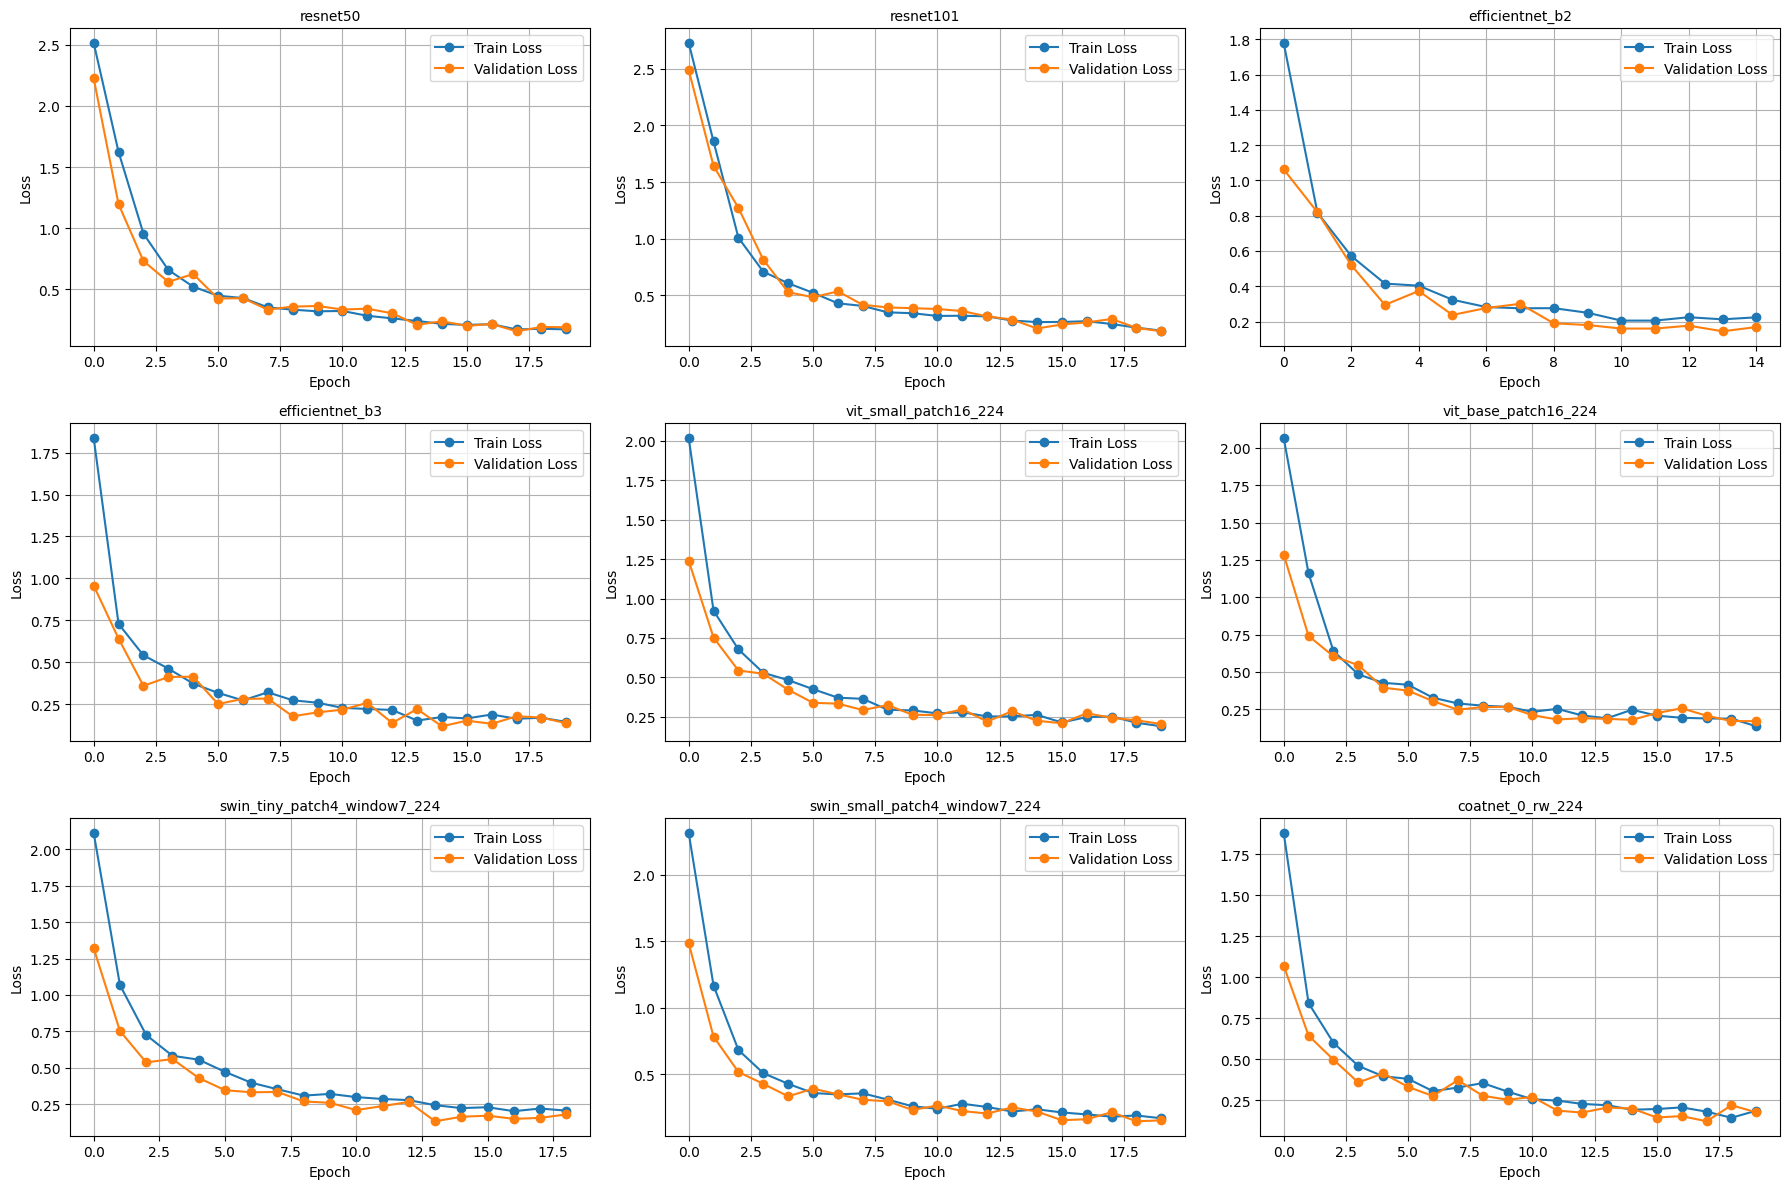

In [5]:
# CSV 파일 목록
csv_files = [
    "/home/logs1_resnet50.csv",
    "/home/logs2_resnet101.csv",
    "/home/logs3_efficientnet_b2.csv",
    "/home/logs4_efficientnet_b3.csv",
    "/home/logs5_vit_small_patch16_224.csv",
    "/home/logs6_vit_base_patch16_224.csv",
    "/home/logs7_swin_tiny_patch4_window7_224.csv",
    "/home/logs8_swin_small_patch4_window7_224.csv",
    "/home/logs9_coatnet_0_rw_224.csv",
]

# 여러 CSV 파일에 대해 Loss 그래프 그리기 (3x3 그리드)
def plot_loss_multiple(csv_files):
    num_files = len(csv_files)
    rows = 3
    cols = 3

    fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
    axes = axes.flatten()  # 2D 배열을 1D로 변환

    for idx, csv_file in enumerate(csv_files):
        # 파일 이름에서 모델 이름 추출
        model_name = csv_file.split('/')[-1].replace('.csv', '')

        # 데이터 읽기
        data = pd.read_csv(csv_file)

        # 현재 서브플롯 선택
        ax = axes[idx]

        # Plot train_loss
        ax.plot(data['epoch'], data['train_loss'], label='Train Loss', marker='o')

        # Plot val_loss
        ax.plot(data['epoch'], data['val_loss'], label='Validation Loss', marker='o')

        # 그래프 설정
        ax.set_title(f'{model_name[6:]}', fontsize=10)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True)

    # 빈 플롯 숨기기
    for ax in axes[num_files:]:
        ax.axis('off')

    # 전체 레이아웃 설정
    plt.tight_layout()
    plt.savefig('/home/logs_loss_plots.png')  # 모든 그래프를 하나의 이미지로 저장
    plt.show()

# 함수 실행
plot_loss_multiple(csv_files)

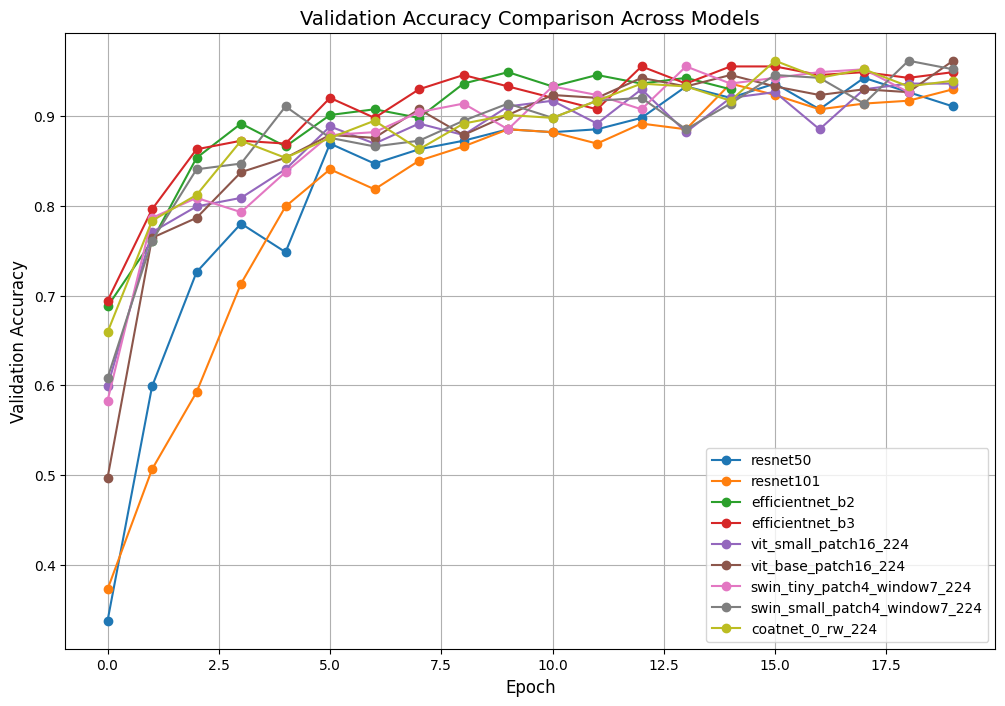

In [5]:
def plot_val_acc_comparison(csv_files):

    plt.figure(figsize=(12, 8))

    for csv_file in csv_files:
        # 파일 이름에서 모델 이름 추출
        model_name = csv_file.split('/')[-1].replace('.csv', '')[6:]

        # 데이터 읽기
        data = pd.read_csv(csv_file)

        # Validation Accuracy 플롯
        plt.plot(data['epoch'], data['val_acc'], label=model_name, marker='o')

    # 그래프 설정
    plt.title('Validation Accuracy Comparison Across Models', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Validation Accuracy', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True)

    # 그래프 저장
    plt.savefig('/home/val_acc_comparison.png')  # 그래프를 이미지로 저장
    plt.show()

# 예제 실행
csv_files = [
    '/home/logs1_resnet50.csv',
    '/home/logs2_resnet101.csv',
    '/home/logs3_efficientnet_b2.csv',
    '/home/logs4_efficientnet_b3.csv',
    '/home/logs5_vit_small_patch16_224.csv',
    '/home/logs6_vit_base_patch16_224.csv',
    '/home/logs7_swin_tiny_patch4_window7_224.csv',
    '/home/logs8_swin_small_patch4_window7_224.csv',
    '/home/logs9_coatnet_0_rw_224.csv'
]

plot_val_acc_comparison(csv_files)

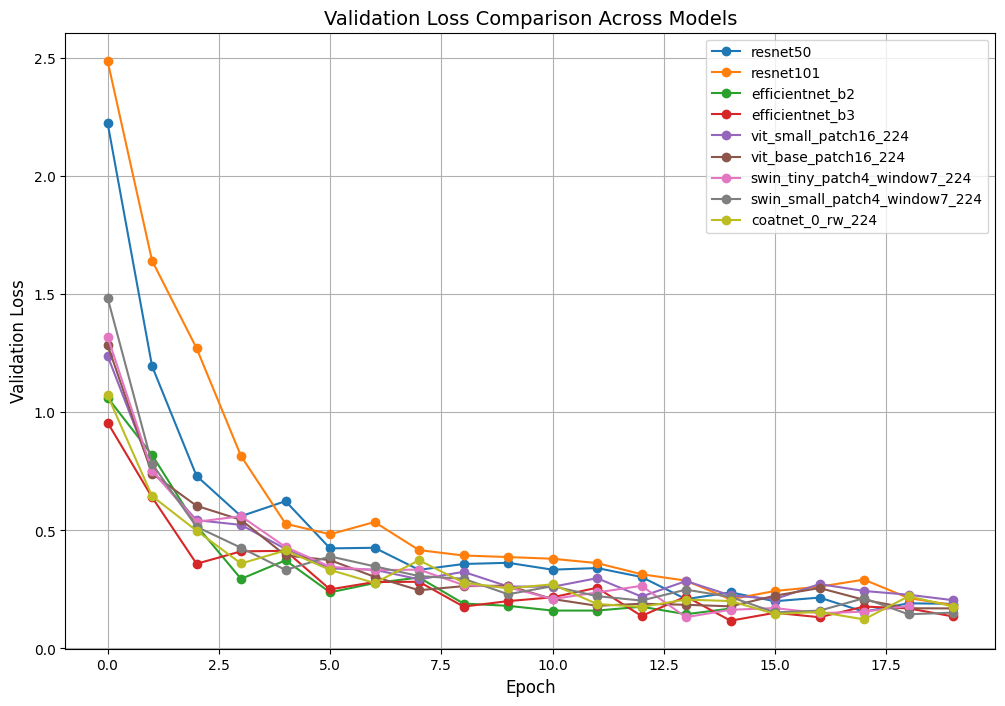

In [6]:
# 여러 CSV 파일의 Validation Loss를 한 그래프에 비교
def plot_val_acc_comparison(csv_files):
    plt.figure(figsize=(12, 8))

    for csv_file in csv_files:
        # 파일 이름에서 모델 이름 추출
        model_name = csv_file.split('/')[-1].replace('.csv', '')[6:]

        # 데이터 읽기
        data = pd.read_csv(csv_file)

        # Validation Accuracy 플롯
        plt.plot(data['epoch'], data['val_loss'], label=model_name, marker='o')

    # 그래프 설정
    plt.title('Validation Loss Comparison Across Models', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Validation Loss', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True)

    # 그래프 저장
    plt.savefig('/home/val_loss_comparison.png')  # 그래프를 이미지로 저장
    plt.show()

# 함수 실행
plot_val_acc_comparison(csv_files)

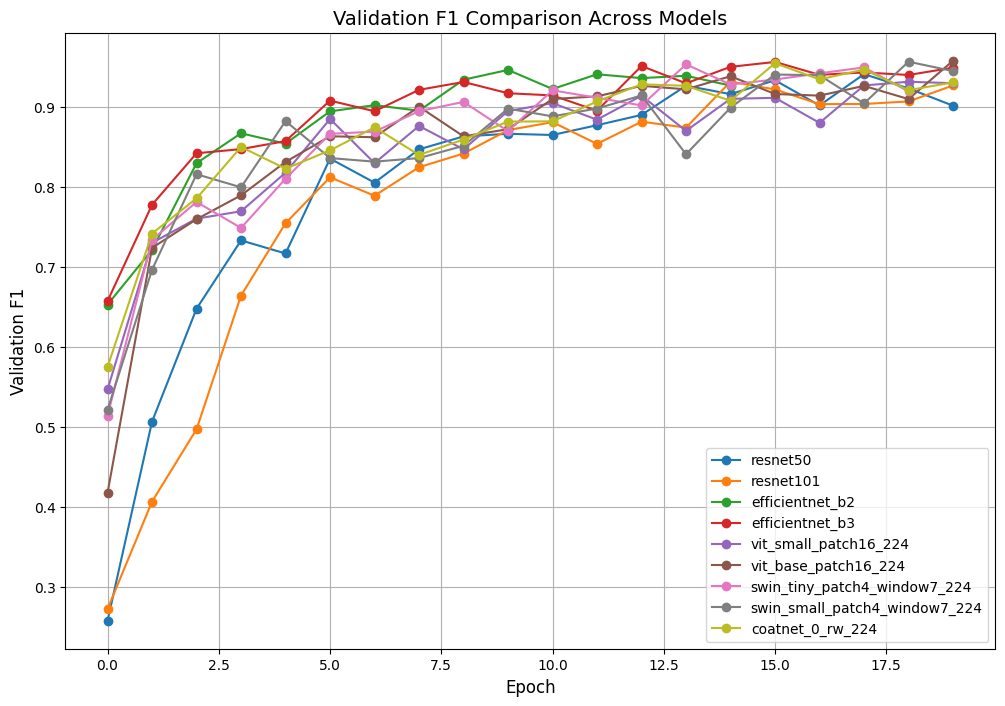

In [7]:
# 여러 CSV 파일의 Validation F1를 한 그래프에 비교
def plot_val_acc_comparison(csv_files):
    plt.figure(figsize=(12, 8))

    for csv_file in csv_files:
        # 파일 이름에서 모델 이름 추출
        model_name = csv_file.split('/')[-1].replace('.csv', '')[6:]

        # 데이터 읽기
        data = pd.read_csv(csv_file)

        # Validation Accuracy 플롯
        plt.plot(data['epoch'], data['val_f1'], label=model_name, marker='o')

    # 그래프 설정
    plt.title('Validation F1 Comparison Across Models', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Validation F1', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True)

    # 그래프 저장
    plt.savefig('/home/val_f1_comparison.png')  # 그래프를 이미지로 저장
    plt.show()

# 함수 실행
plot_val_acc_comparison(csv_files)